In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Importing required libreries

In [37]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
import random
from matplotlib import image 
import matplotlib.cm as cm
import os
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

#### We install a different version of OpenCV. This is because SIFT feature descriptor is not available is latest version due to patent issues.

In [38]:
!pip install opencv-python==3.4.2.17 opencv-contrib-python==3.4.2.17


#### Below are the classes we have for classification. We have assigned a unique interger to each class as a part of preprocessing

In [39]:
classes = ['aquarium', 'desert', 'park', 'windmill', 'waterfall', 'highway', 'kitchen', 'laundromat']
LABELS = {'aquarium'  :1,
          'desert'    :2,
          'park'      :3,
          'windmill'  :4,
          'waterfall' :5,
          'highway'   :6,
          'kitchen'   :7,
          'laundromat':8}

#### These are the target class labels for training and testing. We have 80 samples of each class in training data and 20 samples of each class in test data

In [40]:
y_train = np.array([[1]*80+[2]*80+[3]*80+[4]*80+[5]*80+[6]*80+[7]*80+[8]*80]).flatten()
y_test  = np.array([[1]*20+[2]*20+[3]*20+[4]*20+[5]*20+[6]*20+[7]*20+[8]*20]).flatten()

#### Function of compute SIFT features for a given input image
#### BONUS - DENSE SIFT ALSO DONE
Window size for Dense SIFT is 20x20 and a stride of 5 is taken.

In [42]:
def get_features(image):
  sift = cv2.xfeatures2d.SIFT_create()
  kp, des = sift.detectAndCompute(image, None)
  return des

def get_dense_sift_features(image):
  n ,m, _ = image.shape
  window_size = 20
  stride = 5
  features = np.zeros((1,128))
  #print(features.shape)
  sift = cv2.xfeatures2d.SIFT_create()
  for x in range(0, n-window_size, stride):
    for y in range(0, m-window_size, stride):
      kp, des = sift.detectAndCompute(image[ x : x + window_size, y : y + window_size ], None)
      if des is None:
        continue
      features = np.append(features, des, axis=0)
  return features[1:,:]


### Preprocessing
#### In below function, we prepare the training and testing data one by one. Following the steps involved : 
- INITIALIZE DATASET AS EMPTY
  - We read each image of each class sequentially
  - Resize image to 150 x 150
  - Calculate SIFT descriptors of reduced image
  - Append calculated descriptors of the image to dataset. 


In [47]:
def load_data_and_preprocess(PATH, feature_type="sift"):
  data = np.zeros(128)
  labels = np.zeros(1)
  features = []
  for class_ in classes:
    img_path = PATH + class_ 
    print(class_, LABELS[class_])
    for filename in os.listdir(img_path):
      img = cv2.imread(os.path.join(img_path,filename))
      img = cv2.resize(img, (150, 150))
      if (feature_type=="dense-sift"):
        desc = get_dense_sift_features(img)
      else:
        desc = get_features(img)
      label = np.zeros(desc.shape[0]) + LABELS[class_]
      labels = np.append(labels, label)
      features.append(desc)
      data = np.vstack((data,desc)) 
  data = data[1:]
  labels = labels[1:]
  return data, features, labels

#### Preparing training dataset

In [55]:
train_path = '/content/drive/My Drive/COMPUTER VISION/SUN_data/SUN_data/train/'
data, features, labels = load_data_and_preprocess(train_path, feature_type="dense-sift")

aquarium 1
desert 2
park 3
windmill 4
waterfall 5
highway 6
kitchen 7
laundromat 8


#### Preparing testing dataset

In [ ]:
test_path = '/content/drive/My Drive/COMPUTER VISION/SUN_data/SUN_data/test/'
data_test, features_test, labels_test = load_data_and_preprocess(test_path, feature_type="dense-sift")

aquarium 1
desert 2
park 3
windmill 4
waterfall 5
highway 6
kitchen 7
laundromat 8


### Kmeans CLustering
#### Here, we take the input dataset (set of all SIFT feature descriptors of all images) and perform kmeans clustering on them. This is done to get descriptor of same things together in a same cluster as a part of bag of visual words technique.

In [49]:
def clustering(Xtrain, num_clusters):
    kmeans = KMeans(n_clusters = num_clusters)
    kmeans.fit(Xtrain)
    return kmeans

### BOVW for Retrieval : Inverted File Indexing
#### In this function, we create the index table. Following are the steps involved : 
- INITIALIZE : Zero matrix of size ( No. of cluster X No. of Images)
 
We'll call this matrix as ***INDEX TABLE*** from now onwards
 - Go through each feature descriptor in dataset
  - Predict its cluster accoring to the clustering done in previous step using kmeans
  - Increament the corressponding entry in index table.

In [50]:
def inverted_file_indexing( features, Kmeans, num_clusters):
  num_images = len(features)
  index_table = np.zeros((num_clusters, num_images))
  print(num_images,index_table.shape)
  for i in range(num_images):
    for feature in features[i]:
      Feature = feature.reshape(1, 128)
      cluster_idx = Kmeans.predict(Feature)[0]
      index_table[cluster_idx][i] += 1
  return index_table

#### Histogram PLotting
##### Below function is used to plot the histogram of cluster obtained after applying clustering on the feature descriptors of all images

In [51]:
def display_orig_BOVW_histogram(index_table  ,num_clusters ):
  x_scalar = np.arange(num_clusters)
  y_scalar = np.sum(index_table, axis=1)
  plt.figure(figsize=(15,8))
  plt.bar(x_scalar, y_scalar)
  plt.xlabel("Visual Word Index")
  plt.ylabel("Frequency")
  plt.title("Complete Vocabulary Generated")
  #plt.xticks(x_scalar + 0.4, x_scalar)
  plt.show()

### Normalization
#### In this section, we have normalized the Index Table. This is done by subtracting the mean and dividing by standard deviation

Normalized data = ( Data - Mean ) / Standard_deviation

After normalization, we have performed classification using the normalized index table.

In [ ]:
def normalize(index_table, index_table_test):
  normalized_index_table = np.copy(index_table)
  Mean = np.mean(normalized_index_table, axis=0)
  std_dev = np.std(normalized_index_table, axis=0)
  normalized_index_table = (normalized_index_table - Mean)/std_dev

  normalized_index_table_test = np.copy(index_table_test)
  Mean = np.mean(normalized_index_table_test, axis=0)
  std_dev = np.std(normalized_index_table_test, axis=0)
  normalized_index_table_test = (normalized_index_table_test - Mean)/std_dev
  return normalized_index_table, normalized_index_table_test

def fit_normalized(index_table, index_table_test):
  normalized_index_table, normalized_index_table_test = normalize()
  norm_clf = applySVM(normalized_index_table.T, y_train)
  y_pred = norm_clf.predict(normalized_index_table_test.T)
  print(accuracy_score(y_test, y_pred))
  print(confusion_matrix(y_test, y_pred))


### Evaluation
#### - Here we have done the following : 
- Predictions for the testing
- Calculation of accuracy
- Computing Confusion matrix

In [ ]:
def prediction(classifier, index_table_test, y_test):
    y_pred = classifier.predict(index_table_test.T)
    print("y_pred",y_pred.shape)
    acc = accuracy(y_pred, y_test)
    conf_mat = print_confusion_matrix(y_pred, y_test)
    return acc, conf_mat

def accuracy(y_pred, y_test):
    #print(accuracy_score(y_test, y_pred))
    return accuracy_score(y_test, y_pred)

def print_confusion_matrix(y_pred, y_test):
    #print(confusion_matrix(y_test, y_pred))
    return confusion_matrix(y_test, y_pred)

### Classification
#### Support vector machine is used for classifying. We have used applyied various hyparameters like kernel, C, gamma etc. 
Since we have 8 classes in this problem so we are using 1 vs all classification.

In [ ]:
def applySVM(trainX, trainY, c=10, Kernel="linear", Gamma=5):
    #clf = OneVsRestClassifier(SVC( C = c, gamma = Gamma, kernel = Kernel ) )
    clf = OneVsRestClassifier(SVC() )
    print("....",trainX.shape, trainY.shape)
    clf.fit(trainX, trainY)
    return clf

In [ ]:
Xtrain, Xtest = data, data_test

In [ ]:
print(data.shape)
print(labels.shape)
print(data_test.shape)
print(labels_test.shape)
print(len(features), len(features_test))
print(Xtrain.shape, y_train.shape, Xtest.shape, y_test.shape)

(96122, 128)
(96122,)
(24674, 128)
(24674,)
640 160
(96122, 128) (640,) (24674, 128) (160,)


#### Here we have done the following :
- Clustering on ***training*** dataset
- Creating Inverted Index table for ***training*** dataset
- Clustering on ***testing*** dataset
- Creating Inverted Index table for ***testing*** dataset
- Training 1 vs all SVM classifier on training inverted index table

In [ ]:
num_clusters = 100
kmeans = clustering(Xtrain, num_clusters)  # Xtrain, num_clusters
index_table = inverted_file_indexing(features, kmeans, num_clusters) #features, Kmeans, num_clusters
print(index_table.shape, index_table)
kmeans_test = clustering(Xtest, num_clusters) # Xtrain, num_clusters
index_table_test = inverted_file_indexing(features_test, kmeans_test, num_clusters) #features, Kmeans, num_clusters
print(index_table_test.shape, index_table_test)
clf = applySVM(index_table.T, y_train, c=10, Kernel="rbf", Gamma=5) # trainX, trainY, c=10, Kernel="linear", Gamma=5
acc, conf_mat = prediction(clf, index_table_test, y_test)    

640 (100, 640)
(100, 640) [[2. 1. 0. ... 0. 5. 4.]
 [2. 3. 0. ... 0. 0. 3.]
 [0. 0. 0. ... 1. 4. 1.]
 ...
 [3. 2. 0. ... 1. 3. 0.]
 [5. 0. 0. ... 1. 2. 5.]
 [5. 1. 0. ... 1. 2. 2.]]
160 (100, 160)
(100, 160) [[0. 0. 0. ... 0. 1. 1.]
 [0. 1. 0. ... 3. 1. 0.]
 [1. 4. 1. ... 6. 1. 0.]
 ...
 [1. 6. 2. ... 1. 2. 0.]
 [1. 1. 0. ... 2. 0. 1.]
 [1. 0. 0. ... 0. 1. 0.]]
.... (640, 100) (640,)
y_pred (160,)


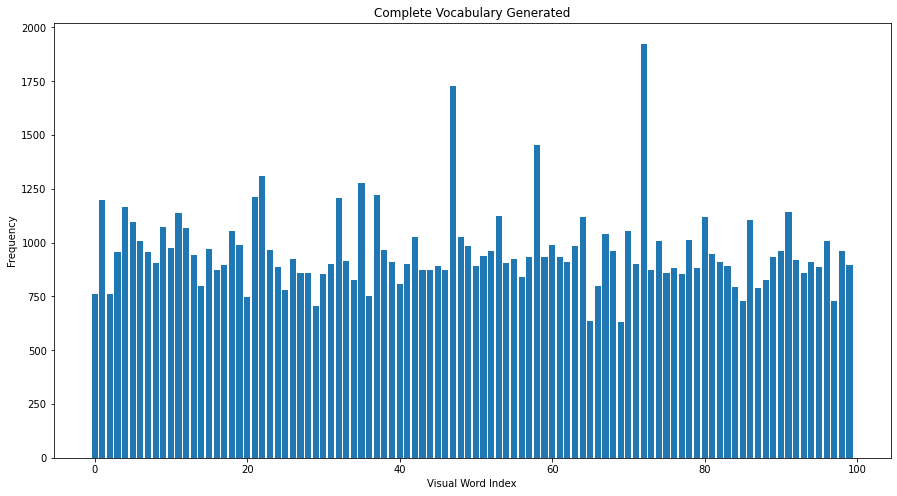

In [57]:
display_orig_BOVW_histogram(index_table  ,num_clusters )

#### Accuracy and confusion matrix for 1-vs-All SVM with RBF kernel 

In [ ]:
print("Accuracy =",acc)
print("Confusion matrix\n",conf_mat)

Accuracy = 0.24375
Confusion matrix
 [[ 5  4  4  1  1  0  1  4]
 [ 2 15  0  0  1  0  0  2]
 [ 4  0  5  0  3  2  3  3]
 [ 4  8  4  0  0  0  2  2]
 [ 1  0  4  1  5  0  2  7]
 [ 3  8  1  1  0  1  4  2]
 [ 3  2  1  0  3  1  4  6]
 [ 1  2  2  0  0  2  9  4]]


#### Accuracy and confusion matrix for 1-vs-All SVM with Linear kernel 

In [ ]:
clf = applySVM(index_table.T, y_train, c=10, Kernel="linear", Gamma=5) # trainX, trainY, c=10, Kernel="linear", Gamma=5
print("after clf training")
prediction(clf, index_table_test, y_test)

.... (640, 100) (640,)
after clf training
y_pred (160,)
0.13125
[[ 1  1  2  7  3  2  3  1]
 [ 1  8  0  1  0  2  4  4]
 [ 1  1  3  3  9  1  1  1]
 [ 1  8  1  4  1  2  2  1]
 [ 2  0  1  6  2  2  5  2]
 [ 0  3  1  2  2  0 12  0]
 [ 3  0  1  8  0  2  2  4]
 [ 3  7  2  3  0  2  2  1]]


### BONUS :  TF-IDF : Term Frequency (TF) - Inverse Document Frequency (IDF)
Weighting on the histograms to enhance the importance of discriminative features and downweight the uninformative features that occur in a lot of images.

n = Number Of Images

m = No. Of Images Containing The visual word

$IDF = Log(\frac{n}{m})$

***Words which are present in less number of images are more discriminative and have high IDF value which is used to weight them***

x = No. of repetitions of visual word in an image

y = Total No. of visual words in an image

$TF = \frac{x}{y}$


In [ ]:
def TF_IDF(index_table, index_table_test, num_clusters):
  tf_train = np.copy(index_table)
  tf_test = np.copy(index_table_test)
  idf_train = np.zeros(num_clusters) + index_table.shape[1]
  idf_test = np.zeros(num_clusters) + index_table_test.shape[1]
  # IDF calculation
  for i in range(num_clusters):
    idf_train[i] = np.log( idf_train[i] / np.sum(index_table[i,:]) )
    idf_test[i]  = np.log( idf_test[i] / np.sum(index_table_test[i,:]) )
  
  tf_train_sum = np.sum(tf_train, axis=0)
  tf_test_sum = np.sum(tf_test, axis=0)

  for i in range(100):
    tf_train[i,:] =  idf_train[i] * (tf_train[i,:]/tf_train_sum[i])
    tf_test[i,:] =  idf_test[i] * (tf_test[i,:]/tf_test_sum[i])

  return tf_train, tf_test

In [ ]:
tf_train, tf_test = TF_IDF(index_table, index_table_test, num_clusters)

In [ ]:
clf = applySVM(tf_train.T, y_train, c=10, Kernel="linear", Gamma=5) # trainX, trainY, c=10, Kernel="linear", Gamma=5
print("after clf training")
acc, conf_mat = prediction(clf, tf_test, y_test)

.... (640, 100) (640,)
after clf training
y_pred (160,)


### Result after applying SVM on TF-IDF re-weighed data

In [ ]:
print("Accuracy =",acc)
print("Confusion matrix\n",conf_mat)

Accuracy = 0.14375
Confusion matrix
 [[ 2 17  1  0  0  0  0  0]
 [ 0 20  0  0  0  0  0  0]
 [ 0 18  1  1  0  0  0  0]
 [ 4 16  0  0  0  0  0  0]
 [ 0 19  0  1  0  0  0  0]
 [ 1 17  2  0  0  0  0  0]
 [ 1 16  0  2  0  0  0  1]
 [ 2 16  0  2  0  0  0  0]]


### BONUS - BOVW with spatial pyramid matching

Number of pyramid levels = 3 

Weights for Layer 1, 2 and 3 are 1/4, 1/4 and 1/2.

Layer 1 : Entire image is taken as itself.

Layer 2 : 4 equal partitions are taken of the image.

Layer 3 : 16 equal partitions are taken of the image.

Hence, the number of histograms that we get are 1+4+16 = 21

Now, for n clusters, the total number of features that we get after concating all histograms is 21*n

In [ ]:
def make_histogram(features, kmeans, num_clusters):
  hist = np.zeros(num_clusters)
  if features is None:
    return hist
  for feature in features:
    pred = kmeans.predict([feature])
    hist[pred] += 1
  return hist

def get_spatial_pyramid_histogram(image, L, kmeans, num_clusters):
  all_histograms = []
  weights = [0.25, 0.25, 0.5]
  for level in range(L):
      size = 2**level
      stride = image.shape[0]//size
      height, width, _ = image.shape
      for i in range(0, height, stride):
        for j in range(0, width, stride):
          img_portion = image[i:i+stride, j:j+stride, :]
          desc = get_features(img_portion)
          hist = make_histogram(desc, kmeans, num_clusters)
          all_histograms.append( weights[level]*hist )

  cumulative_hist = all_histograms[0]
  lenn = len(all_histograms)
  for i in range(1, lenn):
    cumulative_hist = np.concatenate((cumulative_hist, all_histograms[i]))
  cumulative_hist = ( cumulative_hist - np.mean(cumulative_hist) ) / np.std(cumulative_hist)
  return cumulative_hist


In [ ]:
num_clusters = 100

def load_spatial_data(PATH):
  data = np.zeros(2100)
  for class_ in classes:
    img_path = PATH + class_ 
    print(class_, LABELS[class_])
    for filename in os.listdir(img_path):
      img = cv2.imread(os.path.join(img_path,filename))
      img = cv2.resize(img, (160, 160))
      desc = get_spatial_pyramid_histogram(img, 3, kmeans, num_clusters)
      data = np.vstack((data,desc)) 
  data = data[1:]
  return data

In [ ]:
Xtrain_pyd = load_spatial_data(train_path)

aquarium 1
desert 2
park 3
windmill 4
waterfall 5
highway 6
kitchen 7
laundromat 8


In [ ]:
Xtest_pyd = load_spatial_data(test_path)

aquarium 1
desert 2
park 3
windmill 4
waterfall 5
highway 6
kitchen 7
laundromat 8


In [ ]:
print(Xtrain_pyd.shape,Xtest_pyd.shape)

(640, 2100) (160, 2100)


In [ ]:
clf = applySVM(Xtrain_pyd, y_train, c=10, Kernel="linear", Gamma=5) # trainX, trainY, c=10, Kernel="linear", Gamma=5
print("after clf training")
acc, conf_mat = prediction(clf, Xtest_pyd.T, y_test)

.... (640, 2100) (640,)
after clf training
y_pred (160,)


In [ ]:
print("Accuracy =",acc)
print("Confusion matrix\n",conf_mat)

Accuracy = 0.51875
Confusion matrix
 [[13  0  3  3  1  0  0  0]
 [ 0 15  0  1  2  1  0  1]
 [ 2  0 12  0  2  2  0  2]
 [ 0  8  3  4  1  2  1  1]
 [ 1  0  5  1 13  0  0  0]
 [ 1  4  1  2  2  6  2  2]
 [ 2  0  2  0  2  0 11  3]
 [ 1  0  2  0  0  3  5  9]]
